# Magnetostatisches Feld eines Linienstroms

In [137]:
import numpy as np
from matplotlib import pyplot as plt

#plt.figure(figsize=(3, 3))
drift = 0.001
xmin, xmax = -20.00001, 20.000010
ymin, ymax = -20.000010, 20.000010
zmin, zmax = -20.000010, 20.000010

xsamples = 2 ** 8
ysamples = 2 ** 8
zsamples = 2 ** 8

xrange = np.linspace(xmin, xmax, num=xsamples)
yrange = np.linspace(ymin, ymax, num=ysamples)
zrange = np.linspace(zmin, zmax, num=zsamples)
dx = xrange[1] - xrange[0]
dy = yrange[1] - yrange[0]
dz = zrange[1] - zrange[0]

x, z = np.meshgrid(xrange, yrange)

phi = np.linspace(-np.pi, np.pi, num=xsamples)
R = 5
def r(_phi):
    return R*np.array([np.cos(_phi), np.sin(_phi), np.zeros_like(_phi)])

def j(_phi):
    return R*np.array([-np.sin(_phi), np.cos(_phi), np.zeros_like(_phi)])

#r_ = r(phi)

def cross(a,b):
    c = np.zeros_like(a)
    c[0] = a[1]*b[2] - a[2]*b[1]
    c[1] = a[2]*b[0] - a[0]*b[2]
    c[2] = a[0]*b[1] - a[1]*b[0]
    return c



# Feld auf der Z - Achse (zx ebene)

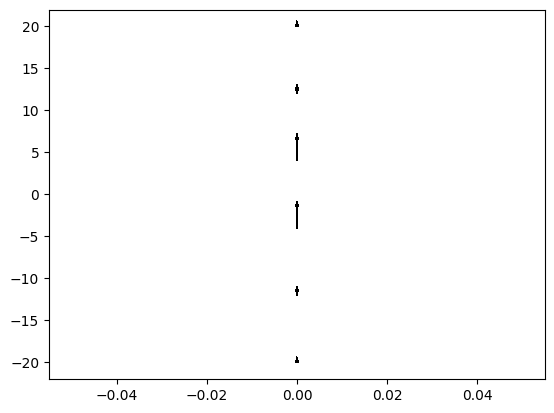

In [138]:

scalar = 0.45/(2*np.sqrt(1+z**2))

field_on_axis = np.array([np.zeros_like(scalar), np.zeros_like(scalar), scalar])

#plt.imshow(scalar, extent=(xmin, xmax, ymin, ymax), origin='lower', vmin=0, vmax=1)
#plt.colorbar()
div = xsamples//5
plt.quiver(np.zeros_like(x)[::div],z[::div], field_on_axis[0][::div],field_on_axis[2][::div],scale=1)

# Potenzial

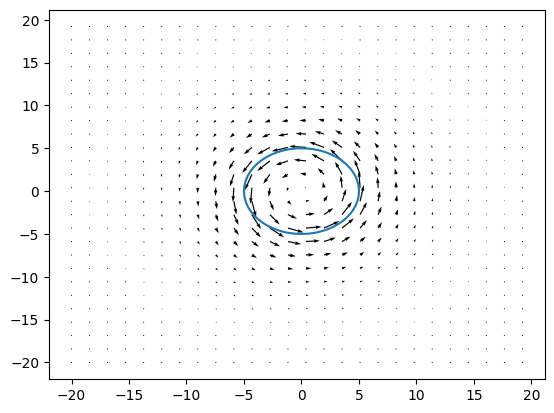

In [139]:

x, y = np.meshgrid(xrange, yrange)

kurve = r(phi)
plt.plot(kurve[0],kurve[1])

orts_vec = np.array([x,y])
field= np.zeros_like(orts_vec)
dphi = phi[1] - phi[0]
for _phi in phi:    
    r_x,r_y,r_z = r(_phi)
    j_x,j_y,j_z = j(_phi)
    distance = np.sqrt(1+(x-r_x)**2+(r_z)**2+(y-r_y)**2) 
    
    field += dphi*np.array([j_x/distance,j_y/distance])
div = 10
plt.quiver(x[::div,::div],z[::div,::div], field[0][::div,::div],field[1][::div,::div], scale=100)

# Feld


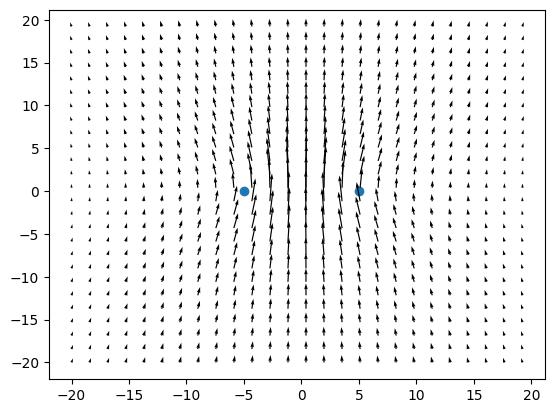

In [142]:
x, z = np.meshgrid(xrange, yrange)

kurve = r(phi)
plt.scatter([-R,R],[0,0])

orts_vec = np.array([x,z])
field= np.zeros_like(orts_vec)
dphi = phi[1] - phi[0]
for _phi in phi:    
    r_x,r_y,r_z = r(_phi)
    to_point = np.array([x-r_x,np.zeros_like(x)-r_y,z-r_z,])
    distance = np.linalg.norm(to_point,axis=0) 
    cr_x,cr_y,cr_z = np.cross(j(_phi),to_point, axis=0)
    field += dphi*np.array([cr_x/distance,cr_z/distance])
div = xsamples//25
plt.quiver(x[::div,::div],z[::div,::div], field[0][::div,::div],field[1][::div,::div], scale=500)

## 1 Analytische Lösung

Idealisierungen:
* unendlich dünner Leiter
* ringförmiger Leiter
* endlicher Radius
* Bestimmung des magnetischen Potenzials und des magnetischen Feldes nur auf der Symmetrieachse.

### 1.1 Herleitung

* siehe Vorlesung
* magnetisches Potenzial
* magnetisches Feld
* in Zylinderkoordinaten
* Lösung auf der Achse in möglichst einfacher Form


**Poisson-Gleichung**
$$
\Delta \vec{A} = -\mu \vec{j}
$$

**Lösung**
$$
\vec{A}(\vec{r}) = \frac{\mu}{4\pi} \iiint \frac{\vec{j}(\vec{r}')}{|\vec{r} - \vec{r}'|} dV'
$$

Der Strom verläuft auf einer Kreisbahn mit Radius $R$. Die Kurve kann durch $\vec{r}(\varphi) = \begin{pmatrix} R \cos(\varphi) \\ R \sin(\varphi) \\ 0 \end{pmatrix}$ beschrieben werden. Die Stromdichte ist konstant und beträgt $I$.

Um das Magnetische Potenzial $\vec{A}$ zu berechnen, müssen wir für jeden Punkt im Raum die durchschnittliche Flussrichtung des Stroms gewichtet mit dem kehrwert des Abstandes berechnen. Dazu integrieren wir über die gesamte Kreisbahn.

$\vec{A}= \frac{\mu_0}{4\pi} \int_0^{2\pi} \frac{I}{R} \begin{pmatrix} -\sin(\varphi) \\ \cos(\varphi) \\ 0 \end{pmatrix} d\varphi$



### 1.2 Visualisierung

* magnetisches Potenzial
* $z$-Komponente des magnetischen Feldes

## 2 Numerische Lösung

### 2.1 Herleitung

* Formeln zur numerischen Berechnung in beliebigem Raumpunkt
    * magnetisches Potenzial: aus der Quellendarstellung
    * magnetisches Feld: aus dem Potenzial
* alles in Zylinderkoordinaten
* Rotationssymmetrie ausnutzen

### 2.2 Berechnung

* Wahl des Integrationsverfahrens
* Wahl des Samplings

### 2.3 Visualisierung

* magnetisches Potenzial
* alle Komponenten des magnetischen Feldes
* alles in Zylinderkoodinaten
* Rotationssymmetrie ausnutzen
* geeignete zweidimensionale Schnitte
* freie Wahl der Bibliothek zum Plotten
    * [Matplotlib](https://matplotlib.org/)
    * [Seaborn](https://seaborn.pydata.org/)
    * [Plotly](https://plotly.com/)
    * [Bokeh](https://bokeh.org/)
    * ...

## 3 Vergleich analytische und numerische Lösung

* Bestimmung des relativen Fehlers
* auf der Symmetrieachse
* magnetisches Potenzial
* $z$-Komponente des magnetischen Feldes
* Visualisierung wie bei der analytischen Lösung
* logarithmisch darstellen

## 4 Verallgemeinerung

* Spule
    * $N$ Windungen
    * Länge $L$
* magnetisches Potenzial und magnetisches Feld
* Vorgehen bei numerischer Berechnung und Visualisierung wie oben

### Fakultativ
* Ringstrom
    * Recherche analytische Lösung (falls möglich, kann kompliziert werden!)
    * Grenzübergang $R\to0$ und Vergleich mit infinitesimalem magnetischem Dipol
        * analytisch
        * numerisch
* Spule
    * Vergleich mit $N$ im Abstand $L/N$ aneinandergereihten Kreisströmen
    * Vergleich mit anderem Team: zylindrischer Permanentmagnet

## 5 Ausblick:  Zeitlich veränderlicher Strom

Idealisierungen:
* unendlich dünner Leiter
* ringförmiger Leiter
* endlicher Radius
* Bestimmung des magnetischen Potenzials und des magnetischen Feldes nur auf der Symmetrieachse.

Verallgemeinerung: *zeitlich veränderlicher* Strom
* quasistatischer Fall
* dynamischer Fall

Nur eine kurze Beschreibung dessen, was zur Bestimmung des zeitlich veränderlichen magnetischen Feldes zu tun wäre - insbesondere ein paar Worte zu den erwarteten Hürden in Bezug auf:
* Zeitkomplexität
* Speicherbedarf
* Genauigkeit